In [1]:
!pip install -U "python-gdcm" pydicom pylibjpeg  # Required for JPEG decompression.
!pip install -U torchvision  # For EfficientNetV2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 61.5 MB/s eta 0:00:00
  Attempting uninstall: pydicom
    Found existing installation: pydicom 2.3.1
    Uninstalling pydicom-2.3.1:
      Successfully uninstalled pydicom-2.3.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 82.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from typing import List
import pylibjpeg
import gc
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom as dicom
import torch
import torchvision as tv
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, KFold
from torch.cuda.amp import GradScaler
from torch.cuda.amp import autocast
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm.notebook import tqdm

import wandb

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [3]:
# Effnet
WEIGHTS = tv.models.efficientnet.EfficientNet_V2_S_Weights.DEFAULT

In [4]:
TRAIN_IMAGES_PATH = '../input/rsna-2022-cervical-spine-fracture-detection/train_images'
TEST_IMAGES_PATH = '../input/rsna-2022-cervical-spine-fracture-detection/test_images'
METADATA_PATH = '../input/rsna-2022-spine-fracture-detection-metadata'
EFFNET_CHECKPOINTS_PATH = '../input/vertebrae-detection-checkpoints'

In [5]:
EFFNET_MAX_TRAIN_BATCHES = 10000
EFFNET_MAX_EVAL_BATCHES = 1000
ONE_CYCLE_MAX_LR = 0.0004
ONE_CYCLE_PCT_START = 0.3
SAVE_CHECKPOINT_EVERY_STEP = 500
N_MODELS_FOR_INFERENCE = 2

In [6]:
os.environ["WANDB_MODE"] = "online"

In [7]:
if os.environ["WANDB_MODE"] == "online":
    try:
        from kaggle_secrets import UserSecretsClient
        os.environ['WANDB_API_KEY'] = UserSecretsClient().get_secret("WANDB_API_KEY")
    except:
        #  We are running on a laptop
        print('running locally')
        TRAIN_IMAGES_PATH = '../input/rsna-2022-cervical-spine-fracture-detection/train_images'
        TEST_IMAGES_PATH = '../input/rsna-2022-cervical-spine-fracture-detection/test_images'
        EFFNET_CHECKPOINTS_PATH = '../input/vertebrae-detection-checkpoints'
        METADATA_PATH = '../input/rsna-2022-spine-fracture-detection-metadata'
        os.environ['WANDB_API_KEY'] = '5644b6b680db460db32dacbe5983e01eb6398aa8'

running locally


In [8]:
DEVICE='cuda' if torch.cuda.is_available() else 'cpu'
if DEVICE == 'cuda':
    BATCH_SIZE = 32
else:
    BATCH_SIZE = 2

Text(0.5, 1.0, 'jpeg')

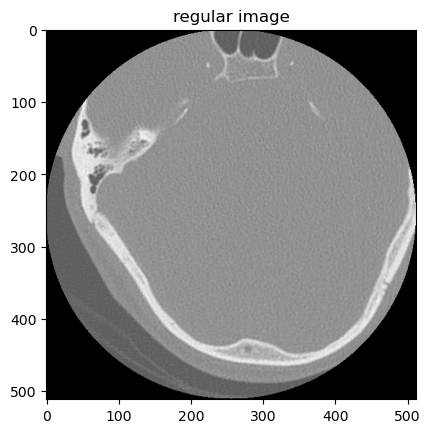

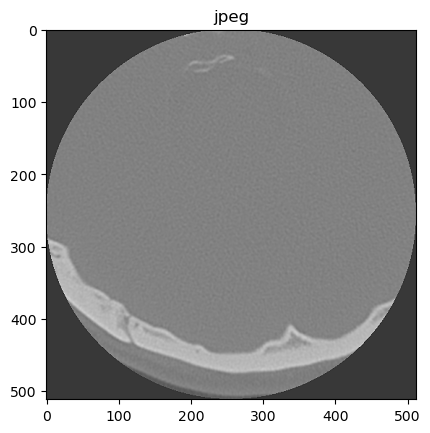

In [9]:
def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images. 
    See the first sell with `pip install` commands for the necessary dependencies
    """
    img=dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data=(data * 255).astype(np.uint8)
    return cv2.cvtColor(data, cv2.COLOR_GRAY2RGB), img


im, meta = load_dicom(f'{TRAIN_IMAGES_PATH}/1.2.826.0.1.3680043.10001/1.dcm')
plt.figure()
plt.imshow(im)
plt.title('regular image')

im, meta = load_dicom(f'{TRAIN_IMAGES_PATH}/1.2.826.0.1.3680043.10014/1.dcm')
plt.figure()
plt.imshow(im)
plt.title('jpeg')

In [10]:
import pandas as pd
df_seg = pd.read_csv(f'{METADATA_PATH}/meta_segmentation.csv')

In [11]:
N_FOLDS = 5
split = GroupKFold(N_FOLDS)
for k, (train_idx, test_idx) in enumerate(split.split(df_seg, groups=df_seg.StudyInstanceUID)):
    df_seg.loc[test_idx, 'split'] = k

In [12]:
split = KFold(N_FOLDS)
for k, (train_idx, test_idx) in enumerate(split.split(df_seg)):
    df_seg.loc[test_idx, 'random_split'] = k

In [13]:
slice_max_seg = df_seg.groupby('StudyInstanceUID')['Slice'].max().to_dict()
df_seg['SliceRatio'] = 0
df_seg['SliceRatio'] = df_seg['Slice'] / df_seg['StudyInstanceUID'].map(slice_max_seg)

In [14]:
df_seg.sample(10)

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,C3,C4,C5,C6,C7,split,random_split,SliceRatio
10483,1.2.826.0.1.3680043.21321,631,512,512,0.625,-97.669000,-54.331000,-240.241000,0,0,0,0,0,0,0,0.0,1.0,0.937593
8936,1.2.826.0.1.3680043.19388,422,512,512,0.600,-89.311523,-272.811523,49.100000,0,0,0,0,0,0,0,4.0,1.0,0.857724
11032,1.2.826.0.1.3680043.21651,507,512,512,1.000,-113.600000,-222.400009,-1061.010010,0,0,0,0,0,0,0,0.0,1.0,0.994118
29172,1.2.826.0.1.3680043.8574,219,512,512,1.000,-77.816406,-283.816406,-128.100000,0,0,0,0,0,0,0,3.0,4.0,0.908714
7195,1.2.826.0.1.3680043.18935,17,512,512,0.625,-60.400000,-39.600000,-23.000000,0,0,0,0,0,0,0,3.0,1.0,0.052308
14488,1.2.826.0.1.3680043.26110,141,512,512,1.000,-161.184600,-299.184600,-435.500000,0,1,0,0,0,0,0,3.0,2.0,0.327907
11474,1.2.826.0.1.3680043.2243,439,512,512,1.000,-74.000000,43.000000,25.700012,0,0,0,0,0,0,0,1.0,1.0,0.986517
18321,1.2.826.0.1.3680043.28025,1,512,512,0.600,-92.826172,-190.826172,-681.500000,0,0,0,0,0,0,0,3.0,3.0,0.002079
4689,1.2.826.0.1.3680043.16919,64,512,512,1.000,-65.394736,68.136842,614.200012,0,0,0,0,0,0,0,1.0,0.0,0.156479
16794,1.2.826.0.1.3680043.26979,120,512,512,0.625,-75.500000,-39.300000,-75.625000,0,1,1,0,0,0,0,2.0,2.0,0.402685


In [15]:
class VertebraeSegmentDataSet(torch.utils.data.Dataset):
    def __init__(self, df, path, transforms=None):
        super().__init__()
        self.df = df
        self.path = path
        self.transforms = transforms

    def __getitem__(self, i):
        path = os.path.join(self.path, self.df.iloc[i].StudyInstanceUID, f'{self.df.iloc[i].Slice}.dcm')
        try:
            img = load_dicom(path)[0]
            img = np.transpose(img, (2, 0, 1))  # Pytorch uses (batch, channel, height, width) order. Converting (height, width, channel) -> (channel, height, width)
            if self.transforms is not None:
                img = self.transforms(torch.as_tensor(img))
        except Exception as ex:
            print(ex)
            return None

        if 'C1' in self.df.columns:
            vert_targets = torch.as_tensor(self.df.iloc[i][['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']].astype('float32').values)
            return img, vert_targets
        return img

    def __len__(self):
        return len(self.df)


In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
ds_seg = VertebraeSegmentDataSet(df_seg, TRAIN_IMAGES_PATH, WEIGHTS.transforms())
X, y = ds_seg[300]
X.shape, y.shape

(torch.Size([3, 384, 384]), torch.Size([7]))

# Vertebrae detection model

Note how we extract 'flatten' layer using introspection capabilities of Pytorch (create_feature_extractor)

In [18]:
class SegEffnetModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        effnet = tv.models.efficientnet_v2_s(weights=WEIGHTS)
        self.model = create_feature_extractor(effnet, ['flatten'])
        self.nn_vertebrae = torch.nn.Sequential(
            torch.nn.Linear(1280, 7),
        )

    def forward(self, x):
        # returns logits
        x = self.model(x)['flatten']
        return self.nn_vertebrae(x)

    def predict(self, x):
        pred = self.forward(x)
        return torch.sigmoid(pred)

In [19]:
# quick test
model = SegEffnetModel()
model.predict(torch.randn(1, 3, 512, 512))
del model

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 234MB/s]


# Model training/evaluation

In [20]:
def gc_collect():
    gc.collect()
    torch.cuda.empty_cache()

In [21]:
def filter_nones(b):
    return torch.utils.data.default_collate([v for v in b if v is not None])

In [22]:
def save_model(name, model, optim, scheduler):
    torch.save({
        'model': model.state_dict(),
        'optim': optim.state_dict(),
        'scheduler': scheduler
    }, f'{name}.tph')


In [23]:
def load_model(model, name, path='.'):
    data = torch.load(os.path.join(path, f'{name}.tph'), map_location=DEVICE)
    model.load_state_dict(data['model'])
    optim = torch.optim.Adam(model.parameters())
    optim.load_state_dict(data['optim'])
    return model, optim, data['scheduler']

In [24]:
# quick test
model = torch.nn.Linear(2, 1)
optim = torch.optim.Adam(model.parameters())
save_model('testmodel', model, optim, None)

In [25]:
model1, optim1, scheduler1 = load_model(torch.nn.Linear(2, 1), 'testmodel')
assert torch.all(next(iter(model1.parameters())) == next(iter(model.parameters()))).item(), "Loading/saving is inconsistent!"

In [26]:
def evaluate_segeffnet(model: SegEffnetModel, ds, max_batches=1e9, shuffle=False):
    torch.manual_seed(42)
    model = model.to(DEVICE)
    dl_test = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle, num_workers=os.cpu_count(), collate_fn=filter_nones)
    with torch.no_grad():
        model.eval()
        pred = []
        y = []
        progress = tqdm(dl_test, desc='Eval', miniters=100)
        for i, (X, y_vert) in enumerate(progress):
            with autocast():
                y_vert_pred = model.predict(X.to(DEVICE))
            pred.append(y_vert_pred.cpu().numpy())
            y.append(y_vert.numpy())
            acc = np.mean(np.mean((pred[-1] > 0.5) == y[-1], axis=0))
            progress.set_description(f'Eval acc: {acc:.02f}')
            if i >= max_batches:
                break
        pred = np.concatenate(pred)
        y = np.concatenate(y)
        acc = np.mean(np.mean((pred > 0.5) == y, axis=0))
        return acc, pred

When we run below cell it will ask for API Key which you can find on https://wandb.ai/authorize

In [27]:
%%wandb


def train_segeffnet(ds_train, ds_eval, logger, name):
    torch.manual_seed(42)
    dl_train = torch.utils.data.DataLoader(
        ds_train, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        num_workers=os.cpu_count(), 
        collate_fn=filter_nones
    )


    model = SegEffnetModel().to(DEVICE)
    optim = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optim, 
        max_lr=ONE_CYCLE_MAX_LR, 
        epochs=1, 
        steps_per_epoch=min(
            EFFNET_MAX_TRAIN_BATCHES, 
            len(dl_train)
        ), 
        pct_start=ONE_CYCLE_PCT_START)
    model.train()
    scaler = GradScaler()

    progress = tqdm(dl_train, desc='Train', miniters=10)
    for batch_idx, (X,  y_vert) in enumerate(progress):

        if batch_idx % SAVE_CHECKPOINT_EVERY_STEP == 0 and EFFNET_MAX_EVAL_BATCHES > 0:
            eval_loss = evaluate_segeffnet(
                model, 
                ds_eval, 
                max_batches=EFFNET_MAX_EVAL_BATCHES, 
                shuffle=True
            )[0]
            model.train()
            if logger is not None:
                logger.log({'eval_acc': eval_loss})
            if batch_idx > 0:  # don't save untrained model
                save_model(name, model, optim, scheduler)

        if batch_idx >= EFFNET_MAX_TRAIN_BATCHES:
            break

        optim.zero_grad()
        with autocast():
            y_vert_pred = model.forward(X.to(DEVICE))
            loss = torch.nn.functional.binary_cross_entropy_with_logits(
                y_vert_pred, 
                y_vert.to(DEVICE)
            )

            if np.isinf(loss.item()) or np.isnan(loss.item()):
                print(f'Bad loss, skipping the batch {batch_idx}')
                del y_vert_pred, loss
                gc_collect()
                continue

        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()
        scheduler.step()

        progress.set_description(f'Train loss: {loss.item():.02f}')
        if logger is not None:
            logger.log({'loss': loss.item(), 'lr': scheduler.get_last_lr()[0]})


    eval_loss = evaluate_segeffnet(
        model, 
        ds_eval, 
        max_batches=EFFNET_MAX_EVAL_BATCHES, 
        shuffle=True
    )[0]
    if logger is not None:
        logger.log({'eval_acc': eval_loss})

    save_model(name, model, optim, scheduler)
    return model


seg_models = []
for fold in range(N_FOLDS):
    fname = os.path.join(f'{EFFNET_CHECKPOINTS_PATH}/segeffnetv2-f{fold}.tph')
    if os.path.exists(fname):
        print(f'Found cached model {fname}')
        seg_models.append(
            load_model(SegEffnetModel(), 
                       f'segeffnetv2-f{fold}',
                       EFFNET_CHECKPOINTS_PATH
                      )[0].to(DEVICE))
    else:
        with wandb.init(project='RSNA-2022', name=f'SegEffNet-v2-fold{fold}') as run:
            gc_collect()
            ds_train = VertebraeSegmentDataSet(
                df_seg.query('split != @fold'), 
                TRAIN_IMAGES_PATH, 
                WEIGHTS.transforms()
            )
            ds_eval = VertebraeSegmentDataSet(
                df_seg.query('split == @fold'), 
                TRAIN_IMAGES_PATH, WEIGHTS.transforms()
            )
            train_segeffnet(
                ds_train, 
                ds_eval, 
                run, 
                f'segeffnetv2-f{fold}'
            )

Found cached model ../input/vertebrae-detection-checkpoints/segeffnetv2-f0.tph
Found cached model ../input/vertebrae-detection-checkpoints/segeffnetv2-f1.tph
Found cached model ../input/vertebrae-detection-checkpoints/segeffnetv2-f2.tph
Found cached model ../input/vertebrae-detection-checkpoints/segeffnetv2-f3.tph
Found cached model ../input/vertebrae-detection-checkpoints/segeffnetv2-f4.tph


In [28]:
print(seg_models)

[SegEffnetModel(
  (model): EfficientNet(
    (features): Module(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Module(
        (0): Module(
          (block): Module(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): Module(
          (block): Module(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=

In [29]:
with tqdm(seg_models, desc='Fold') as progress:
    for fold, model in enumerate(progress):
        ds = VertebraeSegmentDataSet(df_seg.query('split == @fold'), TRAIN_IMAGES_PATH, WEIGHTS.transforms())
        acc, pred = evaluate_segeffnet(model, ds, max_batches=1e9, shuffle=False)
        df_seg.loc[df_seg[df_seg.split == fold].index, ['C1_pred', 'C2_pred', 'C3_pred', 'C4_pred', 'C5_pred', 'C6_pred', 'C7_pred']] = pred
        progress.set_description(f'Acc: {acc}')

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Eval:   0%|          | 0/185 [00:00<?, ?it/s]

Eval:   0%|          | 0/190 [00:00<?, ?it/s]

Eval:   0%|          | 0/185 [00:00<?, ?it/s]

Eval:   0%|          | 0/185 [00:00<?, ?it/s]

Eval:   0%|          | 0/190 [00:00<?, ?it/s]

In [30]:
acc = (df_seg[[f'C{i}_pred' for i in range(1, 8)]] > 0.5).values == (df_seg[[f'C{i}' for i in range(1, 8)]] > 0.5).values
print('Effnetv2 accuracy per vertebrae', np.mean(acc, axis=0))
print('Effnetv2 average accuracy', np.mean(np.mean(acc, axis=0)))

Effnetv2 accuracy per vertebrae [0.96094798 0.94053366 0.95876911 0.96195361 0.95169617 0.94663449
 0.94844462]
Effnetv2 average accuracy 0.9527113741715512
